# Import neccessary libararies

In [4]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import os
import cv2
import random
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Loading the images and converting them to numpy array

In [5]:
def get_data(data_dir, target_size=(256, 256)):
    data = []
    for label in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(data_dir, label)
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            try:
                img = Image.open(file_path).convert('L')
                img = img.resize(target_size) 
                img_array = np.array(img)  
                data.append([img_array, label])
            except (OSError, ValueError) as e:
                print(f"Error processing {file_path}: {e}")
    
    return data

In [6]:
train_data = get_data('D:/Projects/Pneumonia Detector/Dataset/train') 
test_data = get_data('D:/Projects/Pneumonia Detector/Dataset/test')
val_data = get_data('D:/Projects/Pneumonia Detector/Dataset/val')

In [7]:
x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []


for feature, label in train_data:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in test_data:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val_data:
    x_val.append(feature)
    y_val.append(label)

In [8]:
# Normalise

x_train = np.array(x_train)/255
x_test = np.array(x_test)/255
x_val = np.array(x_val)/255

In [9]:
# Resizing

x_train = x_train.reshape(-1,256, 256,1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1,256, 256,1)
y_test = np.array(y_test)

x_val = x_val.reshape(-1,256, 256,1)
y_val = np.array(y_val)

In [10]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

# Data augmentation

In [11]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            rotation_range=30,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            vertical_flip=False,
                            width_shift_range=0.2,
                            height_shift_range=0.2)

datagen.fit(x_train)

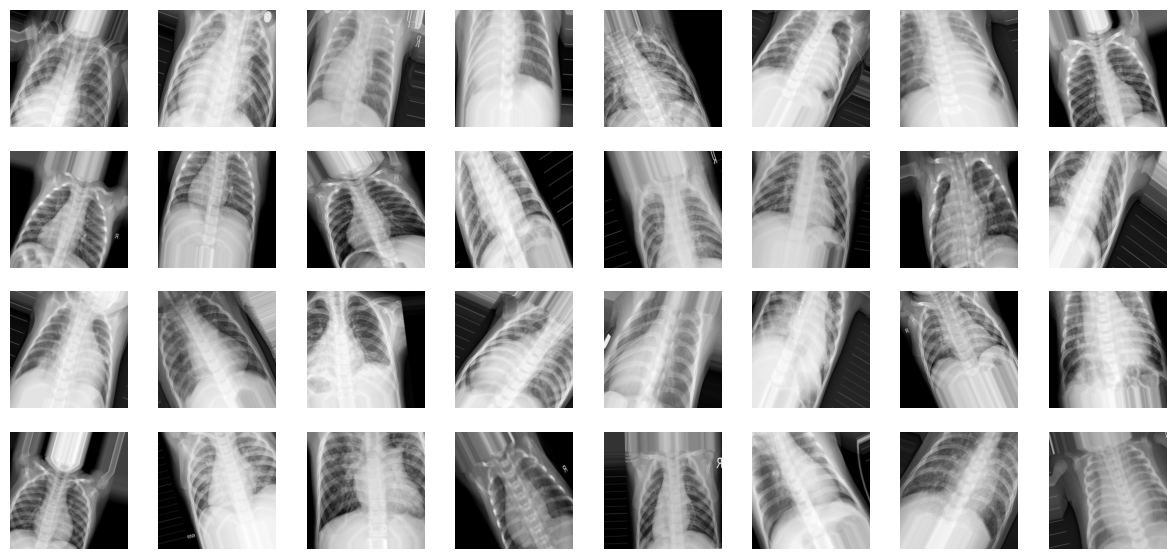

In [12]:
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)
x, y = next(img_iter)

fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(15, 7))
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image), cmap='gray')
    ax.flatten()[i].axis('off')
plt.show()

# Creating and training the model

In [13]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), strides = 1, activation="relu", input_shape = (256, 256, 1), padding = "same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding = "same"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), strides = 1, activation="relu", input_shape = (100, 100, 1), padding = "same"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding = "same"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding = "same"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(units=1024, activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     2

In [15]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss=tf.losses.BinaryCrossentropy(),
             optimizer = opt,
             metrics = ["accuracy"])

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_numeric = le.fit_transform(y_train)
y_val_numeric = le.transform(y_val)

train_generator = datagen.flow(x_train, y_train_numeric, batch_size=32)
val_generator = datagen.flow(x_val, y_val_numeric)

model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

d:\Miniconda\envs\tf\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Miniconda\envs\tf\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/10
183/183 [==============================] - 32s 122ms/step - loss: 0.3264 - accuracy: 0.8649 - val_loss: 1.5504 - val_accuracy: 0.5000
Epoch 2/10
183/183 [==============================] - 22s 120ms/step - loss: 0.2524 - accuracy: 0.8994 - val_loss: 2.6730 - val_accuracy: 0.5000
Epoch 3/10
183/183 [==============================] - 22s 120ms/step - loss: 0.2316 - accuracy: 0.9102 - val_loss: 2.0026 - val_accuracy: 0.5000
Epoch 4/10
183/183 [==============================] - 22s 120ms/step - loss: 0.2142 - accuracy: 0.9122 - val_loss: 2.4952 - val_accuracy: 0.5000
Epoch 5/10
183/183 [==============================] - 22s 120ms/step - loss: 0.2027 - accuracy: 0.9235 - val_loss: 2.0996 - val_accuracy: 0.5000
Epoch 6/10
183/183 [==============================] - 23s 123ms/step - loss: 0.1895 - accuracy: 0.9244 - val_loss: 1.3741 - val_accuracy: 0.5000
Epoch 7/10
183/183 [==============================] - 23s 125ms/step - loss: 0.1893 - accuracy: 0.9291 - val_loss: 1.6470 - val_ac

# Evaluation and prediction

In [17]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Initialize and fit the LabelEncoder on training labels
le = LabelEncoder()
y_train_numeric = le.fit_transform(y_train)

# Transform test labels using the fitted LabelEncoder
y_test_numeric = le.transform(y_test)

# Evaluate the model
eval = model.evaluate(x_test, y_test_numeric)
print(f"Testing Accuracy of the Model is {eval[1] * 100}%")


d:\Miniconda\envs\tf\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Miniconda\envs\tf\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


20/20 [==============================] - 1s 22ms/step - loss: 0.2321 - accuracy: 0.9103
Testing Accuracy of the Model is 91.02563858032227%


In [18]:
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = Image.open(image_path).convert('L')
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array, img

def predict_image_class(model, image_path, target_size=(256, 256), threshold=0.5):
    img_array, img = load_and_preprocess_image(image_path, target_size)
    
    predictions = model.predict(img_array)
    probability = predictions[0][0]  # Assuming binary classification
    predicted_label = 'PNEUMONIA' if probability > threshold else 'NORMAL'
    
    return predicted_label, probability, img

def list_image_files(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.png', '.jpg', '.jpeg'))]

def predict_random_images(model, normal_dir, pneumonia_dir, sample_size=10, target_size=(256, 256), threshold=0.5):
    normal_images = list_image_files(normal_dir)
    pneumonia_images = list_image_files(pneumonia_dir)
    normal_samples = random.sample(normal_images, min(sample_size, len(normal_images)))
    pneumonia_samples = random.sample(pneumonia_images, min(sample_size, len(pneumonia_images)))
    all_samples = normal_samples + pneumonia_samples
    random.shuffle(all_samples)
    
    plt.figure(figsize=(15, 15))
    for i, img_path in enumerate(all_samples):
        predicted_label, probability, img = predict_image_class(model, img_path, target_size, threshold)
        true_label = 'NORMAL' if 'NORMAL' in img_path else 'PNEUMONIA'
        plt.subplot(5, 4, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {predicted_label}\nProb: {probability:.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 21ms/step


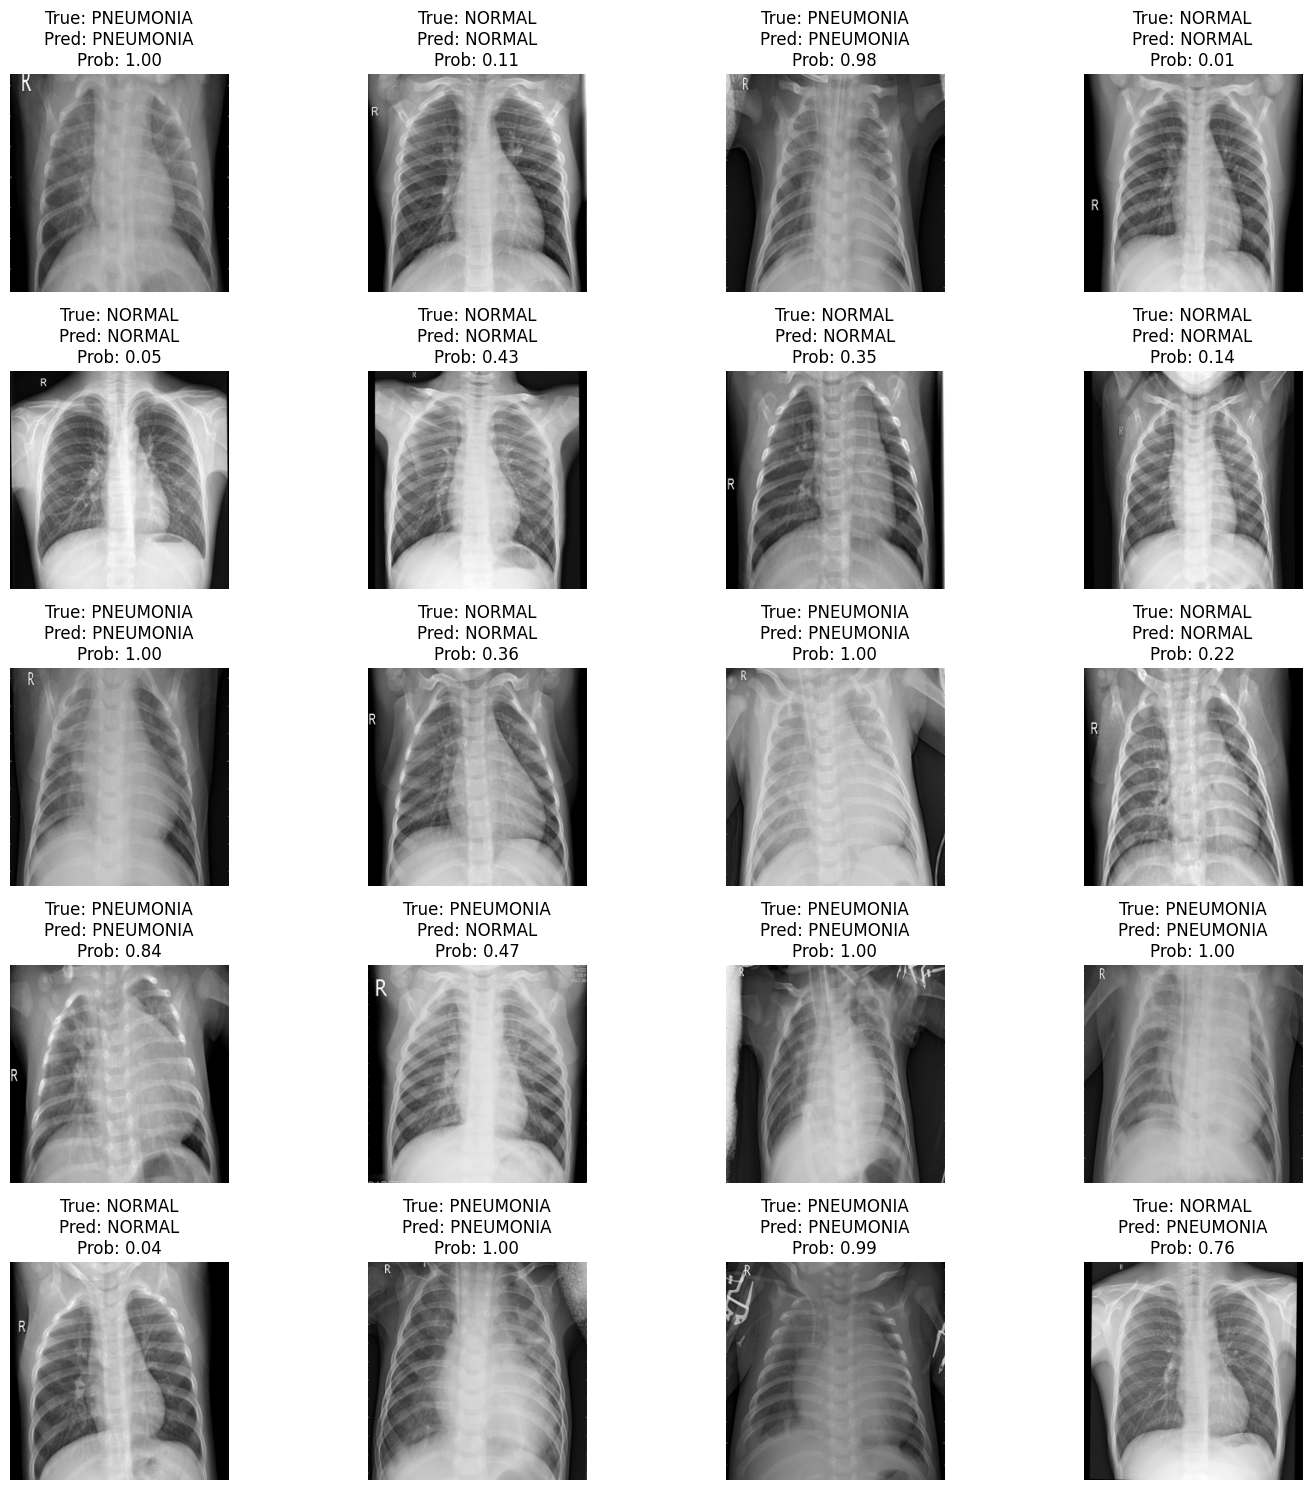

In [19]:
normal_dir = 'D:/Projects/Pneumonia Detector/Dataset/test/NORMAL'
pneumonia_dir = 'D:/Projects/Pneumonia Detector/Dataset/test/PNEUMONIA'
predict_random_images(model, normal_dir, pneumonia_dir, sample_size=10)
